# New logistic regression model
Author: Roddy Jaques <br>
*NHS Blood and Transplant*
***

## Assessing the predictive ability of the logistic regression model 

In this notebook the DCD and DBD datasets are split into training and test sets and a logistic regression fit to the training set. The model fit to the training set is used to predict the family consent for the test set and the metrics for these predictions will be used as a benchmark for the other models fit.  

First the data is imported and a training set and testing set are created for both the DBD and DCD data, with one third of each dataset in the respective testing set.

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import sklearn.metrics as mets
%matplotlib inline

# Function to print confusion matrix, balanced accuracy and accuracy for a set of actual and predicted labels
def show_metrics(actual,predict):
    """ Prints the confusion matrix, balanced accuracy and accuracy given datasets of actual and predicted labels
    
    Arguments:
        actual - Dataset of actual labels
        predict - Dataset of predicted labels
     """
    cm = mets.confusion_matrix(actual, predict)
    
    print("********* MODEL METRIC REPORT *********\n\nConfusion matrix:\n")

    print("TP FN\nFP  TN\n") # this is a reminder of what each part of the confusion matrix means e.g. TP = True Positive
    
    # print the confusion matrix
    print(str(int(cm[0,0])) + "    " + str(int(cm[0,1])))
    print(str(int(cm[1,0])) + "    " + str(int(cm[1,1])) + "\n") 

    # classification report for DBD model
    print("Classification report:\n")
    print(mets.classification_report(actual, predict))

    print("Balanced accuracy: " + str(round(mets.balanced_accuracy_score(actual, predict),2)))

    print("Accuracy: " + str(round(mets.accuracy_score(actual, predict),2)))
    
    # Predicted vs actual consent rates
    cons_rate = int(100 * len(actual[actual=="Consent"]) / len(actual) )
    print("\nActual consent rate: " + str(cons_rate))
    
    pred_rate = int(100 * len(predict[predict=="Consent"]) / len(predict) )
    print("Predicted consent rate: " + str(pred_rate))
    
    pass
 
# Function to format consent column from integer code to text
def format_consent(x):
    if x == 2:
        return "Consent"
    if x == 1:
        return "Non-consent"

In [6]:
# Read in datasets 
dbd_model_data = pd.read_csv("Data/dbd_model_data.csv")
dcd_model_data = pd.read_csv("Data/dcd_model_data.csv")

# Columns used to create DBD model
dbd_cols = ["wish", "FORMAL_APR_WHEN", "donation_mentioned", "app_nature", "eth_grp", "religion_grp", "GENDER", "FAMILY_WITNESS_BSDT", "DTC_PRESENT_BSD_CONV", 
            "acorn_new", "adult","FAMILY_CONSENT"]

dbd_model_data2 = pd.get_dummies(data=dbd_model_data,columns=dbd_cols[:-1],drop_first=True)

dbd_features = dbd_model_data2.drop("FAMILY_CONSENT",axis=1)
dbd_consents = dbd_model_data2["FAMILY_CONSENT"].apply(format_consent)
# Columns used to create DCD model in paper
dcd_cols = ["wish", "donation_mentioned", 
            "app_nature", "eth_grp", "religion_grp", "GENDER", "DTC_WD_TRTMENT_PRESENT", 
            "acorn_new", "adult","cod_neuro","FAMILY_CONSENT"]

dcd_model_data2 = pd.get_dummies(data=dcd_model_data,columns=dcd_cols[:-1],drop_first=True)

dcd_features = dcd_model_data2.drop("FAMILY_CONSENT",axis=1)
dcd_consents = dcd_model_data2["FAMILY_CONSENT"].apply(format_consent)

# creating a train and testing dataset for DBD and DCD approaches
DBD_X_train, DBD_X_test, DBD_y_train, DBD_y_test = train_test_split(dbd_features,dbd_consents, test_size=0.33, random_state=10)

DCD_X_train, DCD_X_test, DCD_y_train, DCD_y_test = train_test_split(dcd_features,dcd_consents, test_size=0.33, random_state=10)

Now logistic regression models are fit with the 'newton-cg' solver and no penalisation and this model is used to predict consent for the testing set. Various model metrics are calculated from the predictions for the testing set.

In [7]:
# fitting DBD logistic regression to training data with same settings as verification model
LR_model = LogisticRegression(penalty='none',solver='newton-cg')

DBD_LR = LR_model.fit(DBD_X_train,DBD_y_train)

DBD_preds = DBD_LR.predict(DBD_X_test)
DBD_prob= DBD_LR.predict_proba(DBD_X_test)

show_metrics(DBD_y_test, DBD_preds)

********* MODEL METRIC REPORT *********

Confusion matrix:

TP FN
FP  TN

1250    132
347    271

Classification report:

              precision    recall  f1-score   support

     Consent       0.78      0.90      0.84      1382
 Non-consent       0.67      0.44      0.53       618

    accuracy                           0.76      2000
   macro avg       0.73      0.67      0.69      2000
weighted avg       0.75      0.76      0.74      2000

Balanced accuracy: 0.67
Accuracy: 0.76

Actual consent rate: 69
Predicted consent rate: 79


In [8]:
# fitting DCD logistic regression to training data with same settings as verification model
LR_model = LogisticRegression(penalty='none',solver='newton-cg')

DCD_LR = LR_model.fit(DCD_X_train,DCD_y_train)

DCD_preds = DCD_LR.predict(DCD_X_test)
DCD_prob= DCD_LR.predict_proba(DCD_X_test)

show_metrics(DCD_y_test, DCD_preds)

********* MODEL METRIC REPORT *********

Confusion matrix:

TP FN
FP  TN

1470    395
467    772

Classification report:

              precision    recall  f1-score   support

     Consent       0.76      0.79      0.77      1865
 Non-consent       0.66      0.62      0.64      1239

    accuracy                           0.72      3104
   macro avg       0.71      0.71      0.71      3104
weighted avg       0.72      0.72      0.72      3104

Balanced accuracy: 0.71
Accuracy: 0.72

Actual consent rate: 60
Predicted consent rate: 62


***
#### DBD model
The DBD model predicts a consent rate of 79% for the training set, which is a 10 percentage point overestimate. The recall (proportion of all non-consents correctly classified) for the non-consent class is lower than for the consent class. This shows the model is better at predicting consents than non-consents. In this context it is as important to identify non-consents as consents, so model performance should be evaluated on metrics that take into account the ability to correctly predict non-consents. <br> 
Balanced accuracy is included in the metric report as this accounts for the model's performance in predicting both classes, where accuracy doesn't. Balanced accuracy will be an important measure when comparing other models. In this model the balanced accuracy is 0.67, lower than the accuracy, 0.76, due to the model predicting consents better than non-consents.

#### DCD model
The DCD model is much more balanced than the DBD model, with the predicted consent rate similar to the actual consent rate, and the balanced accuracy is 0.71, close to the accuracy which is 0.72. The accuracy is 0.4 lower than the DBD model's but balanced accuracy is 0.4 higher, overall this model correctly classifies fewer consents but is better at predicting the non-consent class. The recall for non-consents is 0.18 higher than the DBD model, but for consents the recall is 0.11 lower. The precision (proportion of all predictions in a class that actually belong to the class) for both classes are similar in both models.<br><br>

Neither model had a balanced accuracy high enough for the model predictions to predict consent for organ donation reliably. For other models to be useful, a higher overall accuracy will be needed. The DBD should be more consistent in its ability to predict consents and non-consents.

***
<br>

To further assess this model an ROC curve was plotted and the AUC (or C-statistic) calculated for the DBD and DCD models...

Text(0.5, 1.0, "DBD and DCD ROC curves for 'Consent' class")

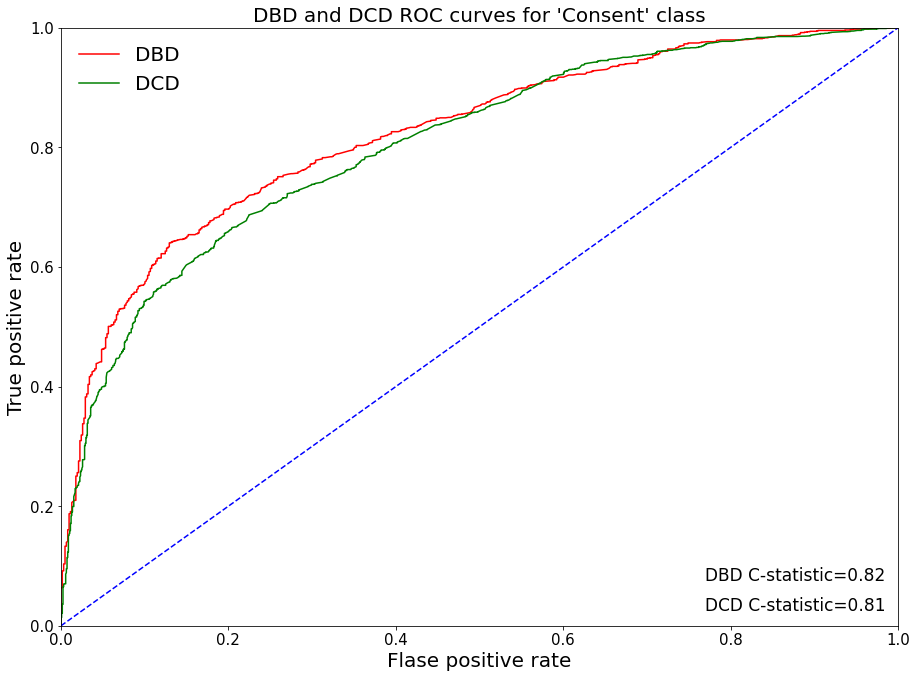

In [47]:
# ROC curve for consent for both models
dbd_roc = mets.roc_curve(DBD_y_test, DBD_prob[:,0], pos_label="Consent")
dbd_auc = mets.roc_auc_score(DBD_y_test, DBD_prob[:,1])
dbd_c_stat = "DBD C-statistic=" + str(round(dbd_auc,2))

dcd_roc = mets.roc_curve(DCD_y_test, DCD_prob[:,0], pos_label="Consent")
dcd_auc = mets.roc_auc_score(DCD_y_test, DCD_prob[:,1])
dcd_c_stat = "DCD C-statistic=" + str(round(dcd_auc,2))


fig, ax = plt.subplots(1,1,figsize=[15,11],facecolor="white")
ax.set_facecolor("white")

# plot DBD and DCD ROC curves on the same axis
ax.plot(dbd_roc[0],dbd_roc[1],"r")
ax.plot(dcd_roc[0],dcd_roc[1],"g")

# plot straight line representing a ROC curve for classifying at random  
ax.plot([0,1],[0,1],"--b")

ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.tick_params(axis="y",labelsize=15)
ax.tick_params(axis="x",labelsize=15)
ax.legend(["DBD","DCD"],loc="best",fontsize=20,frameon=False)

# print AUC (otherwise known as C-Statistic in bottom right corner)
ax.text(0.77,0.075,dbd_c_stat, fontdict={'size':17, 'color':'black'})
ax.text(0.77,0.025,dcd_c_stat, fontdict={'size':17, 'color':'black'})

plt.xlabel("Flase positive rate",size=20)
plt.ylabel("True positive rate",size=20)
plt.title("""DBD and DCD ROC curves for 'Consent' class""",size=20)


The ROC curve and C-statistics confirm what the other metrics showed, that the models are better than random but still is potential to improve. The curve for both DBD and DCD were curved towards the top left of the plot, showing better than random performance, but the area under the curve is not close to 1.<br><br>

In the next Notebook penalisation is added to the logisitic regression model to see if this can improve the model.
***